## INLÄMNING DEL 1

# Bearbeta data
- Läser in data från csv-fil
- Kontrollerar dataset
- Konverterar nödvändiga datatyper till rätt typ

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import norm
#import seaborn as sns

pd.options.display.float_format = "{:.2f}".format

# Välj Seaborn-tema
#sns.set_theme(style="whitegrid")

#Load dataset
df = pd.read_csv("data/health_study_dataset.csv")


#Clean whitespace from necessary columns and convert to categorical
pattern = r"^\s|\s$"
cat_cols = ["sex", "smoker"]

for col in cat_cols:
    if df[col].astype(str).str.contains(pattern, regex=True, na=False).any():
        print(f"{col}: whitespace detected - cleaning")
        df[col] = df[col].astype(str).str.strip()
    else:
        print(f"{col}: clean")
    df[col] = df[col].astype("category")


#Convert disease column to boolean if it only contains 0 and 1
if set(df["disease"].unique()) <= {0, 1}:
    df["disease"] = df["disease"].astype(bool)
    print("Kolumnen 'disease' innehåller endast 0 och 1 - konverterad till bool.")
else:
    print("Kolumnen 'disease' innehåller andra värden - ingen konvertering gjord.")

print(df.dtypes)

#Control unique IDs and remove duplicates
unique_ids = df["id"].nunique()
total_rows = len(df)

if unique_ids < total_rows:
    print(f" Dubbletter hittades baserat på 'id': {total_rows - unique_ids} st")
    df = df.drop_duplicates(subset="id")
    print(f" Dubbletter borttagna. Ny datastorlek: {len(df)} rader")
else:
    print("Alla ID är unika - inga dubbletter hittades.")


sex: clean
smoker: clean
Kolumnen 'disease' innehåller endast 0 och 1 - konverterad till bool.
id                int64
age               int64
sex            category
height          float64
weight          float64
systolic_bp     float64
cholesterol     float64
smoker         category
disease            bool
dtype: object
Alla ID är unika - inga dubbletter hittades.


# Beskrivande analys

              mean  median   std    min    max
age          49.43   50.00 14.50  18.00  90.00
height      171.85  171.35  9.80 144.40 200.40
weight       73.41   73.20 13.69  33.70 114.40
systolic_bp 149.18  149.40 12.79 106.80 185.90
cholesterol   4.93    4.97  0.85   2.50   7.88


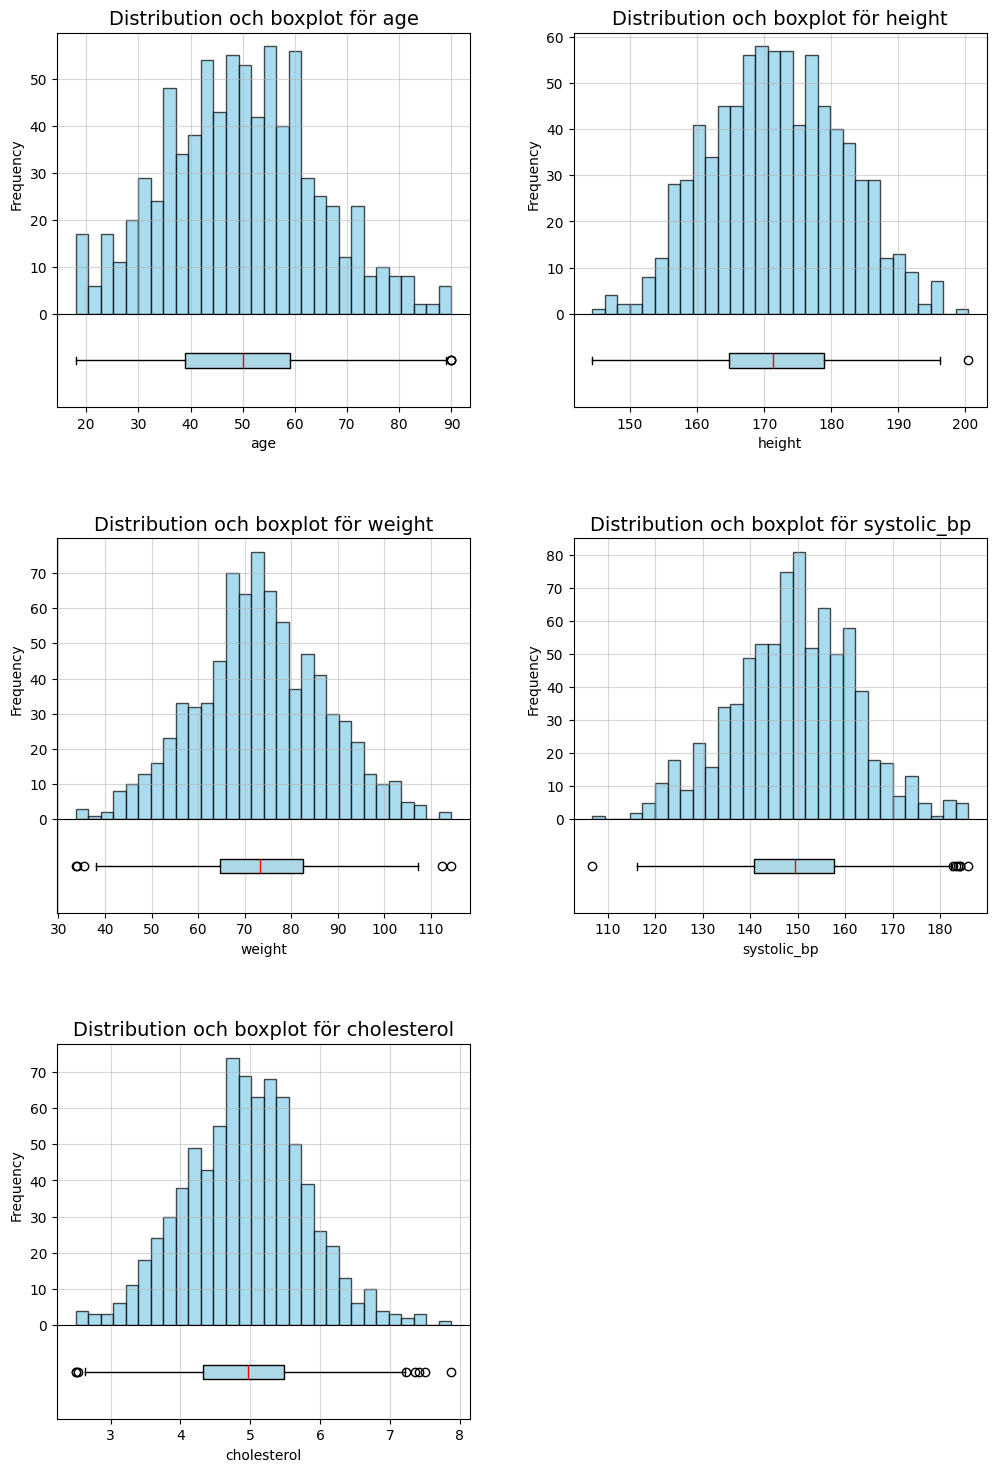

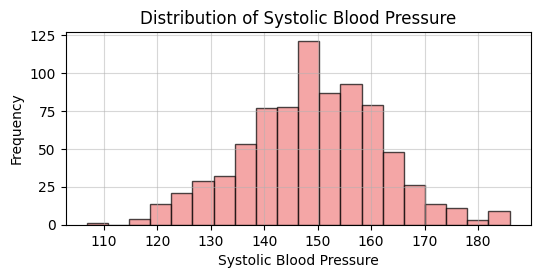

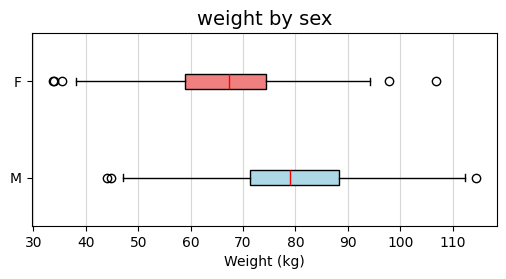

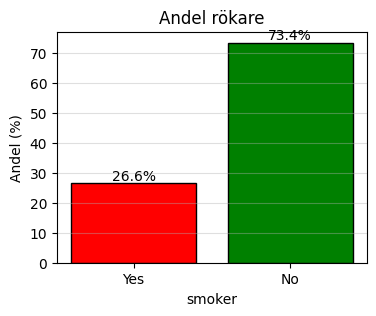

In [3]:
#Calculate summary statistics for numerical columns
num_cols = ["age", "height", "weight", "systolic_bp", "cholesterol"]

summary = df[num_cols].agg(["mean", "median", "std", "min", "max"]).T
print(summary)

#Function for visualization of numerical variable distributions
def plot_hist(data, col, ax, bins=30, color="skyblue"):
    """
    Rita ett histogram för en kolumn.
    """
    ax.hist(data, bins=bins, color=color, edgecolor="black", alpha=0.7)
    ax.set_title(f"Distribution of {col}", fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.grid(axis="both", alpha=0.5)


def plot_box(data, col, ax, color="lightblue", position=1):
    """
    Rita en boxplot för en kolumn.
    """
    kwargs = dict(
        vert=False, patch_artist=True,
        boxprops=dict(facecolor=color, color="black"),
        medianprops=dict(color="red")
    )
    if position is not None:
        kwargs["positions"] = [position]   # <-- placera på vald rad
    
    ax.boxplot(data, **kwargs)
    ax.set_xlabel(col)
    #ax.set_title(f"Boxplot of {col}", fontsize=12)
    ax.set_yticks([]) #tilladga
    ax.set_ylabel("") #tillagda
    ax.grid(axis="x", alpha=0.5)


def plot_group_box(df, value_col, group_col, ax,
                   order=None, colors=None, title=None):
    """
    Rita boxplots för value_col grupperat på group_col i samma axel.
    Använder plot_box-funktion och position.
    """

    # Bestäm gruppordning
    groups = list(df[group_col].dropna().unique()) if order is None else order

    # Standardfärger (M blå, F rosa)
    default_colors = {"M": "lightblue", "F": "lightcoral"} 

    # Loopa och rita en box per grupp på olika positioner
    plotted = []  # håller reda på vilka grupper som faktiskt ritats

    for pos, group in enumerate(groups, start=1):
        data = df.loc[df[group_col] == group, value_col].dropna()
        if data.empty:
            continue
        color = default_colors.get(group, "lightgray") if colors is None else colors.get(group, "lightgray")
        plot_box(data, value_col, ax, color=color, position=pos)
        plotted.append((pos, group))
    
    # Y-etiketter
    if plotted:                      # om minst en grupp ritats
        positions, labels = zip(*plotted)
        ax.set_yticks(positions)
        ax.set_yticklabels(labels)
    else:                               # om inga grupper ritades (alla tomma)
        ax.set_yticks([])

    # Titel
    if title is None:
        ax.set_title(f"{value_col} by {group_col}", fontsize=14)
    else:
        ax.set_title(title, fontsize=14)


def plot_proportion_bar(df, col, ax, title=None, colors=None, order=None):
    """
    Rita ett stapeldiagram över andelar (%) för en kategorisk variabel.
    
    Parameters:
        df : DataFrame
        col : kolumnnamn (kategorisk variabel)
        ax : matplotlib-axel att rita på
        title : (valfritt) figurens titel
        colors : (valfritt) lista eller dict för färger
    """

    # Beräkna andelar (%)
    prop = df[col].value_counts(normalize=True) * 100

    if order is not None:
        prop = prop.reindex(order)
        prop = prop.fillna(0)   

    #Om colors är en dictionary så välj färger i rätt ordning och om inen angivits välj
    if isinstance(colors, dict):
        bar_colors = [colors.get(category, "lightgray") for category in prop.index]
    else:
        bar_colors = colors if colors is not None else "lightblue"

    # Rita stapeldiagram
    ax.bar(prop.index, prop.values, color=bar_colors, edgecolor="black")

    # Etiketter
    ax.set_ylabel("Andel (%)")
    ax.set_xlabel(col)
    ax.set_title(title or f"Andel per kategori i {col}")
    ax.grid(axis="y", alpha=0.4)

    # Visa procenttal ovanför staplarna
    for i, v in enumerate(prop.values):
        ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)



# Layout (Set up grid for plots)
n_cols = 2 #fixed number of columns
n_rows = int(np.ceil(len(num_cols) / n_cols)) #calculate number of rows needed

fig = plt.figure(figsize=(12, 6 * n_rows))

# Yttre grid styr avstånd mellan variabel-par
outer = fig.add_gridspec(n_rows, n_cols, hspace=0.35, wspace=0.25)

for i, col in enumerate(num_cols):
    row_gr = i // n_cols       # radindex (histogram)
    c = i % n_cols  # kolumnindex

    # Inre grid = histogram + boxplot, helt utan mellanrum
    inner = outer[row_gr, c].subgridspec(2, 1, height_ratios=[3, 1], hspace=0.0) # skapar 2 rader, 1 kolumn som fördelar sig 75% överst och 25% nederst

    #Skapa axlarna:
    ax_hist = fig.add_subplot(inner[0])
    ax_box  = fig.add_subplot(inner[1], sharex=ax_hist)
   
    # Rita grafer
    plot_hist(df[col].dropna(), col, ax_hist)
    plot_box(df[col].dropna(), col, ax_box)

    # Ta bort x-axelns etiketter/ticks på histogrammet (övre), behöver göras efter plottning    
    ax_hist.tick_params(axis="x", which="both", labelbottom=False, bottom=False)
    #ax_hist.set_xlabel("")  # ta bort ev. x-label
    ax_hist.spines["bottom"].set_visible(False)

    # Gemensam titel
    ax_hist.set_title(f"Distribution och boxplot för {col}", fontsize=14)
plt.show()

#Histogram över blodtryck
fig, ax = plt.subplots(figsize=(6, 2.5))
plot_hist(
    df["systolic_bp"].dropna(),
    "Systolic Blood Pressure",
    ax,
    bins=20,
    color="lightcoral"
)

#Boxplot över vikt per kön
fig, ax = plt.subplots(figsize=(6, 2.5))
plot_group_box(df, "weight", "sex", ax=ax, order=["M", "F"])
ax.set_xlabel("Weight (kg)")   # ändra x-etikett

plt.show()

#Stapeldiagram över andel rökare och icke-rökare
fig, ax = plt.subplots(figsize=(4, 3))
plot_proportion_bar(df, "smoker", ax, 
                    title="Andel rökare", 
                    colors={"Yes": "red", "No": "green"},
                    order=["Yes", "No"]
                    )
plt.show()


# Simulering kopplad till caset



In [4]:
# Andel personer med sjukdom i riktiga dataset.
real_prop = (df["disease"] == True).mean()
print(f"Andel med sjukdom i datasetet: {real_prop*100:.1f}%")

# Simulera 1000 personer med samma andel
np.random.seed(42)

simulated = np.random.rand(1000) < real_prop #Skapar en lista och blir true och false likt real_prop
#simulated = np.random.choice([True, False], size=1000, p=[real_prop, 1-real_prop])

sim_prop = (simulated == True).mean()
print(f"Andel sjukdom i simuleringen: {sim_prop*100:.1f}%")

#Jämförelse
print(f"Skillnad: {(sim_prop - real_prop)*100:.1f}%")

Andel med sjukdom i datasetet: 5.9%
Andel sjukdom i simuleringen: 6.3%
Skillnad: 0.4%


## Konfidensintervall

In [34]:
# Confidensintervall for systolic_bp

# Confidence interval using normal approximation
def ci_norm(series, confidence = 0.95):
    # Validering
    if not (0 < confidence < 1):
        raise ValueError("confidence måste ligga mellan 0 och 1.")
    
    x = np.asarray(series.dropna(), dtype=float)
    mean = x.mean()
    std = x.std(ddof=1)
    n=len(x)

    alpha=1-confidence
    # z-värde för vald konfidensnivå
    z = 1.96 if alpha == 0.05 else norm.ppf(1 - alpha/2)

    se = std/np.sqrt(n) #standardfel

    
    ci_lower = mean - z*se
    ci_upper = mean + z*se

    level = int(round(confidence*100))
    print(f"Medelvärde: {mean:.2f}")
    print(f"{level}% CI (normalapprox): [{ci_lower:.2f}, {ci_upper:.2f}]")

    return  float(mean), (float(ci_lower), float(ci_upper))  

ci_norm(df["systolic_bp"], 0.95)


# Confidence interval using bootstrap Percentile CI

def ci_mean_boot_perc(series, confidence=0.95, n_boot=20_000, random_state=42):
    # Validering
    if not (0 < confidence < 1):
        raise ValueError("confidence måste ligga mellan 0 och 1.")
    
    x = np.asarray(series.dropna(), dtype=float)
    n = len(x)
    if n == 0:
        raise ValueError("Ingen data kvar efter dropna().")
    
    mean_x = float(x.mean())
    rng = np.random.default_rng(random_state)

    # Ver1 Sampla index → medelvärden 
    idx = rng.integers(0, n, size=(n_boot,n))
    boot_mean = x[idx].mean(axis=1)

    # Ver 2. LOOP: skapa ett resample i taget
    # boot_mean = np.empty(n_boot,dtype=float)

    # for i in range(n_boot):
    #     boot_sample = rng.choice(x, size=n, replace=True)
    #     boot_mean[i] = boot_sample.mean()

    alpha = 1 - confidence
    lo = float(np.quantile(boot_mean, alpha/2)) # vid alfa=0,5 2,5% av bootstrapmedelvärderna lugger under lo
    hi = float(np.quantile(boot_mean, 1-alpha/2)) #se ovan, gräns där 97,5% ligger under vid alfa=0,5

    level = int(round(confidence*100))
    print(f"Medelvärde: {mean_x:.2f}")
    print(f"{level}% CI (bootstrap): [{lo:.2f}, {hi:.2f}]")
    return mean_x, (lo, hi), #boot_mean

ci_mean_boot_perc(df["systolic_bp"], 0.95)
    

def ci_mean_boot_bca(series, confidence=0.5, n_boot=20_000, random_state=42):
    # Validering
    if not (0 < confidence < 1):
        raise ValueError("confidence måste ligga mellan 0 och 1.")
    
    x = np.asarray(series.dropna(), dtype=float)
    n = len(x)
    if n == 0:
        raise ValueError("Ingen data kvar efter dropna().")
    
    mean_x = float(x.mean())
    rng = np.random.default_rng(random_state)

    # Bootstrap med återinläggningar
    idx = rng.integers(0, n, size=(n_boot,n))
    boot_mean = x[idx].mean(axis=1)

    # Bootstrap correction (z0)
    # proportion av bootstrap-medelvärden < observerade medelvärdet
    prop = (boot_mean < mean_x).mean() #Om inte 0.5 så är bootstrapfördelningen förskjuten (bias)
    z0 = norm.ppf(prop) #korrigeringsfaktor, transformeras till en z-värde

    # Acceleration (a) — justerar för skevhet, baserat på jackknife 
    sumx = x.sum()
    loo_means = (sumx - x) / (n - 1)  # LOO-mean: medelvärdet om varje observation tas bort i tur och ordning
    jack_mean = loo_means.mean() #Genomsnitt av LOO-means

    num = np.sum((jack_mean - loo_means)**3)
    den = 6 * (np.sum((jack_mean - loo_means)**2))**1.5
    a = num/den if den != 0 else 0.0 #Om 0 så finns ingen skevhetskorrigering

    #BCa kvantiljustering
    alpha = 1 - confidence

    def bca_quantile(p):
        z = norm.ppf(p)
        adj = z0 + (z0 + z) / (1 - a * (z0 + z))   # BCa transformation
        return float(np.quantile(boot_mean, norm.cdf(adj)))

    lo = bca_quantile(alpha/2)
    hi = bca_quantile(1 - alpha/2)

    level = int(round(confidence*100))
    print(f"Medelvärde: {mean_x:.2f}")
    print(f"{level}% CI (bootstrap BCa): [{lo:.2f}, {hi:.2f}]")

    return mean_x, (lo, hi), boot_mean

ci_mean_boot_bca(df["systolic_bp"], 0.95)

Medelvärde: 149.18
95% CI (normalapprox): [148.29, 150.07]
Medelvärde: 149.18
95% CI (bootstrap): [148.30, 150.07]
Medelvärde: 149.18
95% CI (bootstrap BCa): [148.29, 150.06]


(149.178625,
 (148.29004357007656, 150.0596250044706),
 array([149.59025 , 148.946875, 149.305625, ..., 149.023875, 149.298125,
        149.644   ], shape=(20000,)))

## Hypotesprövning

Hypotes: Rökare har högre medel-blodtryck än icke-rökare